In [4]:
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import random
import glob

In [8]:
Data_dir = "/kaggle/input/garbage-classification/garbage_classification"

In [9]:
categories = os.listdir(Data_dir)
print("categories : " , categories)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/garbage-classification/garbage_classification'

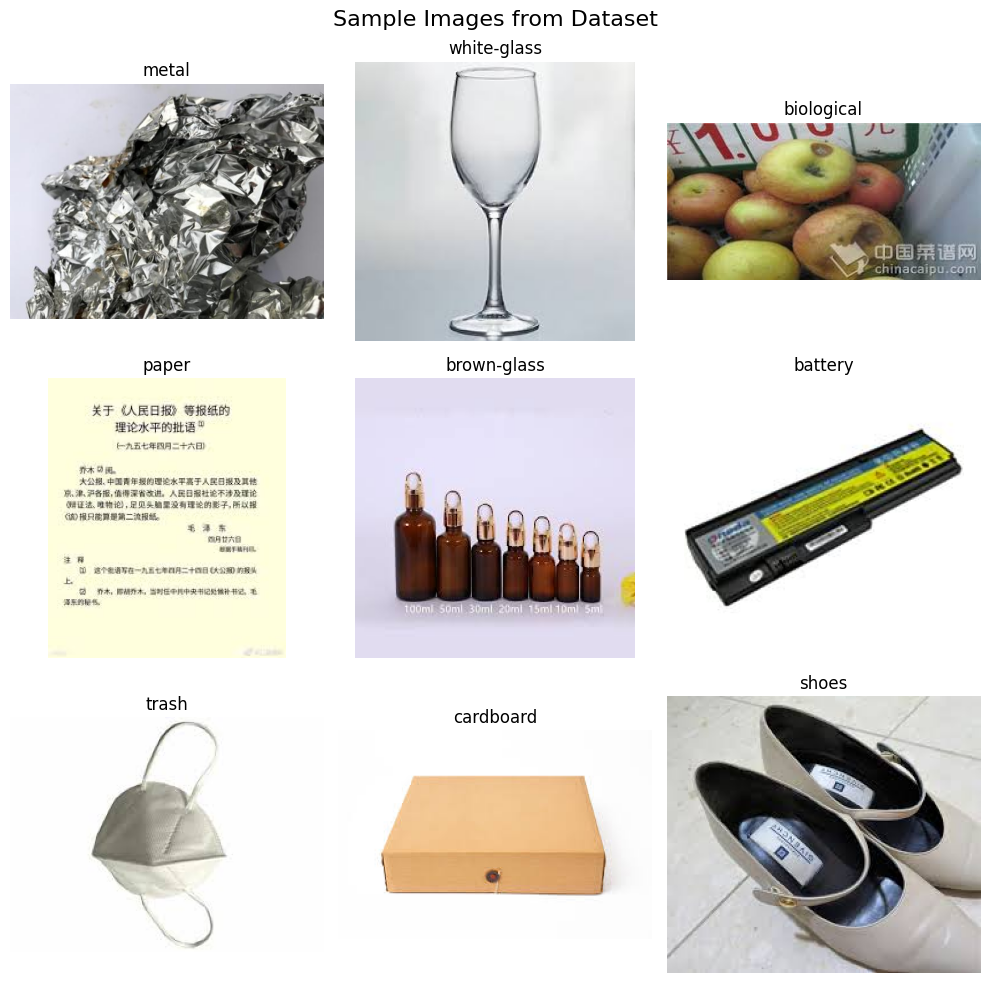

In [ ]:
# print smples
plt.figure(figsize=(10, 10))
for i, category in enumerate(categories[:9]):
    folder = os.path.join(Data_dir, category)
    img_path = random.choice(glob.glob(folder + "/*.jpg"))
    img = plt.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-10-30 17:08:27.809844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761844107.992930      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761844108.058500      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Augmantation

In [ ]:
IMG_SIZE =(224,224)
BATCH_SIZE = 32

In [ ]:
# image generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    Data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_gen = train_datagen.flow_from_directory(
    Data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_gen.class_indices)
print("Number of classes:", num_classes)
print("Class mapping:", train_gen.class_indices)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Number of classes: 12
Class mapping: {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}


# Build MobileNetV2 Model

In [ ]:
base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'  
)
base_model.trainable = False  # freez all layers

#add my custum layers
inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,500 (9.24 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train Model
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=2)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 191s 464ms/step - accuracy: 0.6953 - loss: 1.0214 - val_accuracy: 0.8606 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 167s 431ms/step - accuracy: 0.8714 - loss: 0.4099 - val_accuracy: 0.8745 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 174s 447ms/step - accuracy: 0.8910 - loss: 0.3475 - val_accuracy: 0.8794 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 169s 436ms/step - accuracy: 0.8986 - loss: 0.3159 - val_accuracy: 0.8823 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 168s 432ms/step - accuracy: 0.9015 - loss: 0.2941 - val_accuracy: 0.8877 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 167s 431ms/step - accuracy: 0.9105 - loss: 0.2825 - val_accuracy: 0.8771 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 168s 434ms/step - accura

# Visualize Loss & accuracy

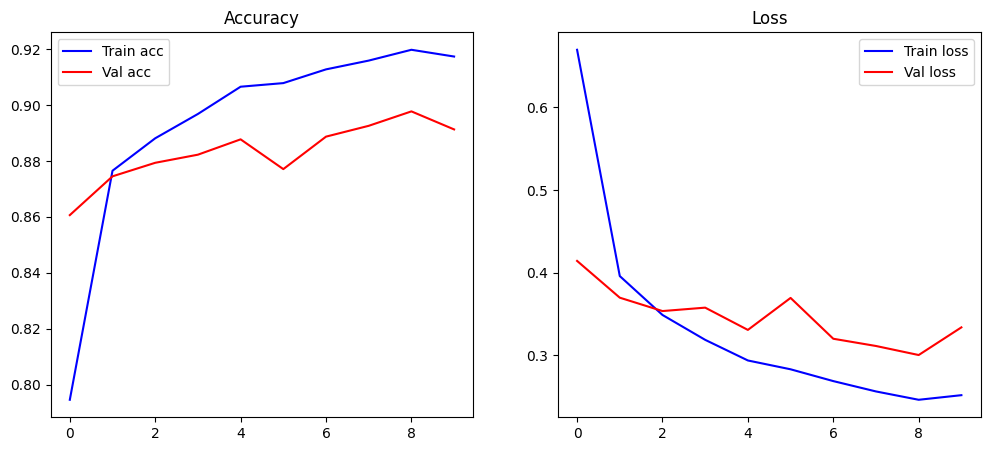

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'b', label='Train acc')
plt.plot(history.history['val_accuracy'], 'r', label='Val acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b', label='Train loss')
plt.plot(history.history['val_loss'], 'r', label='Val loss')
plt.legend(); plt.title("Loss")
plt.show()

# Model Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


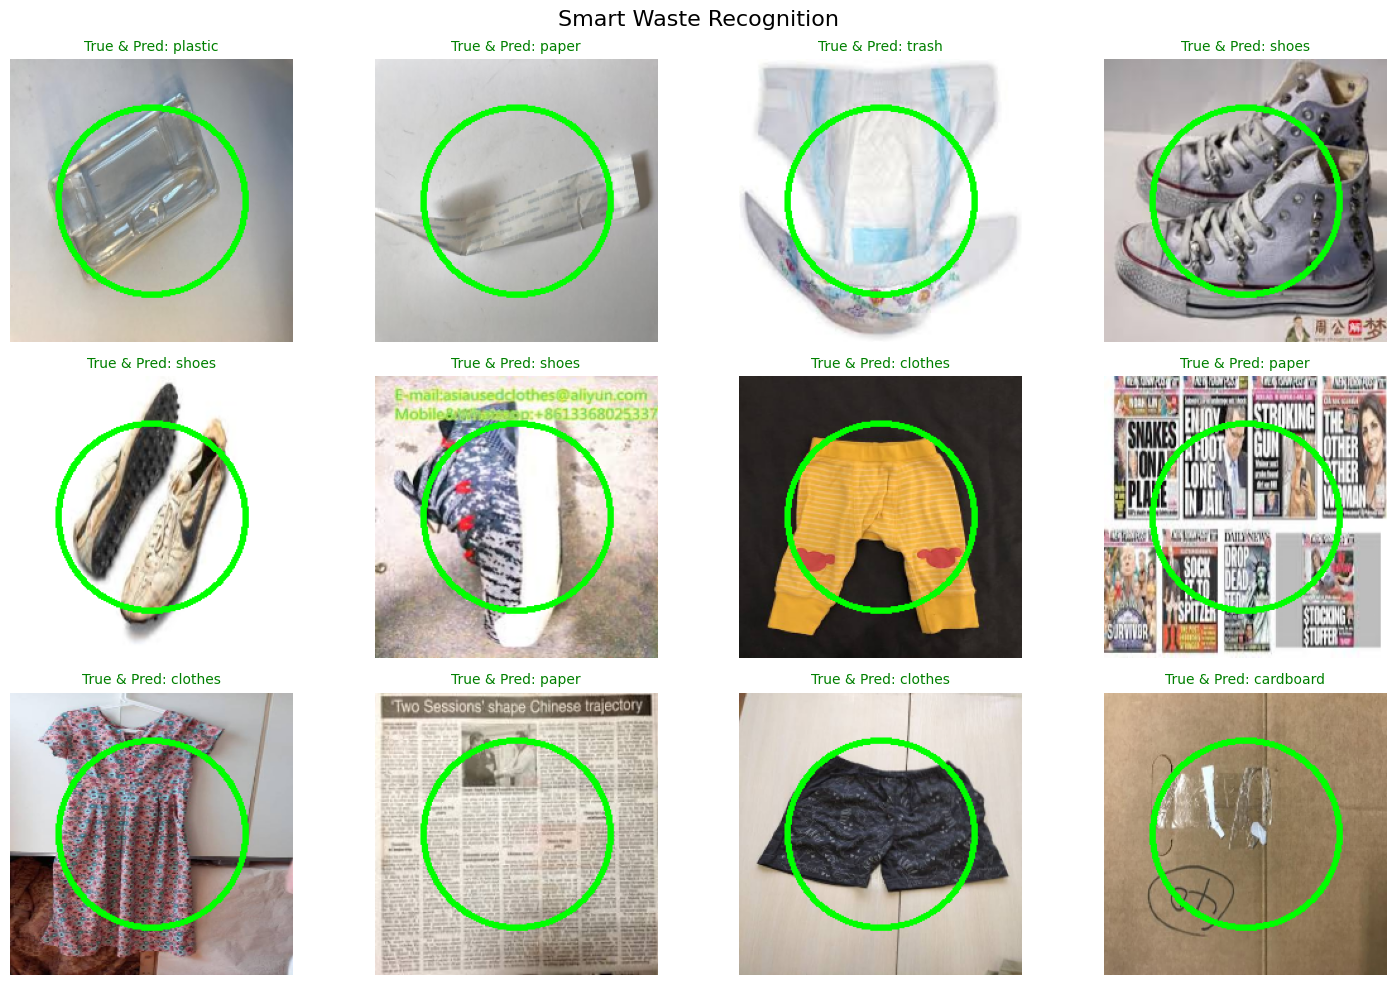

In [ ]:
class_labels = list(train_gen.class_indices.keys())

sample_paths = random.sample(val_gen.filepaths, 20)

correct_images = []

for img_path in sample_paths:
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))
    pred_label = class_labels[np.argmax(pred)]
    true_label = os.path.basename(os.path.dirname(img_path))

    if pred_label == true_label:
        correct_images.append((img_path, true_label, pred_label))
plt.figure(figsize=(15,10))
for i, (img_path, true_label, pred_label) in enumerate(correct_images[:12]):  
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(cv2.resize(img_cv, IMG_SIZE), cv2.COLOR_BGR2RGB)

    h, w, _ = img_cv.shape
    center = (w//2, h//2)
    radius = min(h, w)//3
    cv2.circle(img_cv, center, radius, (0, 255, 0), 3)

    plt.subplot(3, 4, i+1)
    plt.imshow(img_cv)
    plt.title(f'True & Pred: {true_label}', fontsize=10, color='green')
    plt.axis('off')

plt.suptitle("Smart Waste Recognition", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
model.save("garbage_classification_model.h5") 

NameError: name 'model' is not defined